Original Image Size: 31260.78 KB
Lossy Compressed Image (DCT-based) Size: 24128.76 KB
Lossless Compressed Image (PNG) Size: 31260.78 KB


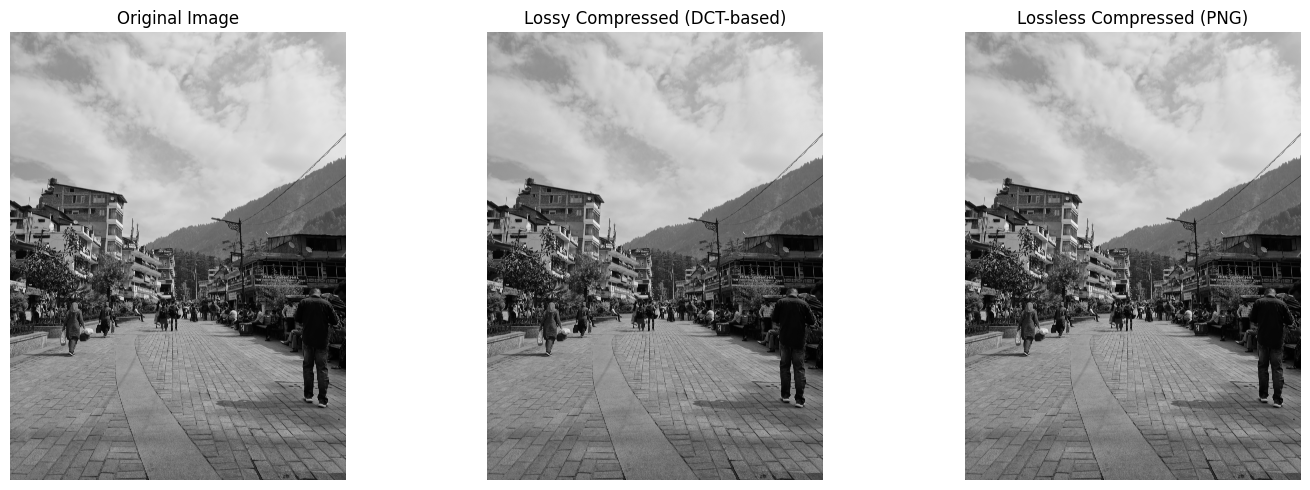

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# JPEG Standard Luminance Quantization Matrix
JPEG_QUANT_MATRIX = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
], dtype=np.float32)

# Function to perform block-wise DCT
def blockwise_dct(image, block_size=8):
    """Applies DCT block-wise to an image."""
    h, w = image.shape
    dct_image = np.zeros_like(image, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i + block_size, j:j + block_size]
            dct_block = cv2.dct(np.float32(block))  # Apply DCT
            dct_image[i:i + block_size, j:j + block_size] = dct_block

    return dct_image

# Function to perform block-wise Inverse DCT
def blockwise_idct(dct_image, block_size=8):
    """Applies Inverse DCT block-wise to an image."""
    h, w = dct_image.shape
    image_reconstructed = np.zeros_like(dct_image, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dct_block = dct_image[i:i + block_size, j:j + block_size]
            block = cv2.idct(dct_block)  # Apply IDCT
            image_reconstructed[i:i + block_size, j:j + block_size] = block

    return image_reconstructed

# Function to apply quantization to DCT coefficients
def quantize_dct(dct_image, quality=50, block_size=8):
    """Quantizes the DCT coefficients using a JPEG-like quantization matrix."""
    if quality < 1:
        quality = 1
    elif quality > 100:
        quality = 100

    # Scale quantization matrix based on quality factor
    scale = 50.0 / quality if quality < 50 else 2 - (quality / 50.0)
    quant_matrix = np.round(JPEG_QUANT_MATRIX * scale).astype(np.float32)

    h, w = dct_image.shape
    quantized_dct = np.zeros_like(dct_image, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i + block_size, j:j + block_size]
            quantized_dct[i:i + block_size, j:j + block_size] = np.round(block / quant_matrix) * quant_matrix  # Quantization

    return quantized_dct

# Function to perform JPEG-like lossy compression using DCT and quantization
def lossy_compression_dct(image, quality=50, block_size=8):
    """Performs JPEG-like lossy compression using DCT, quantization, and IDCT."""
    h, w = image.shape

    # Pad image if necessary to fit block size
    pad_h = (block_size - h % block_size) % block_size
    pad_w = (block_size - w % block_size) % block_size
    padded_image = cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)

    # Step 1: Apply DCT block-wise
    dct_image = blockwise_dct(padded_image, block_size)

    # Step 2: Quantize the DCT coefficients
    quantized_dct = quantize_dct(dct_image, quality, block_size)

    # Step 3: Apply IDCT to reconstruct the image
    reconstructed_image = blockwise_idct(quantized_dct, block_size)

    return np.clip(reconstructed_image, 0, 255).astype(np.uint8)  # Ensure valid pixel values

# Function to perform PNG-like lossless compression
def lossless_compression(image, output_path="compressed_lossless.png"):
    """Saves the image in PNG format to achieve lossless compression."""
    cv2.imwrite(output_path, image)  # Save the image in PNG format
    return output_path  # Return path for reference

# Function to get file size
def get_file_size(file_path):
    """Returns file size in KB."""
    return os.path.getsize(file_path) / 1024  # Convert to KB

# Function to display images
def display_images(original, lossy_path, lossless_path):
    """Displays original, lossy compressed, and lossless compressed images."""
    lossy_image = cv2.imread(lossy_path, cv2.IMREAD_GRAYSCALE)
    lossless_image = cv2.imread(lossless_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(lossy_image, cmap='gray')
    plt.title("Lossy Compressed (DCT-based)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(lossless_image, cmap='gray')
    plt.title("Lossless Compressed (PNG)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Main function
def main(image_path, quality=50):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale

    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Save original image for size comparison
    original_path = "original_image.png"
    cv2.imwrite(original_path, image)

    # Perform DCT-based lossy compression
    lossy_image = lossy_compression_dct(image, quality)

    # Save DCT-compressed image
    lossy_path = "compressed_lossy_dct.png"
    cv2.imwrite(lossy_path, lossy_image)

    # Perform lossless compression (PNG)
    lossless_path = lossless_compression(image)

    # Get file sizes
    original_size = get_file_size(original_path)
    lossy_size = get_file_size(lossy_path)
    lossless_size = get_file_size(lossless_path)

    # Print file size comparison
    print(f"Original Image Size: {original_size:.2f} KB")
    print(f"Lossy Compressed Image (DCT-based) Size: {lossy_size:.2f} KB")
    print(f"Lossless Compressed Image (PNG) Size: {lossless_size:.2f} KB")

    # Display images
    display_images(image, lossy_path, lossless_path)

# Run the main function
if __name__ == "__main__":
    image_path = "/content/test img.jpg"  # Replace with your actual image path
    main(image_path, quality=50)


CNN for MNIST Classification

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8078 - loss: 0.6111 - val_accuracy: 0.9810 - val_loss: 0.0593
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9686 - loss: 0.1075 - val_accuracy: 0.9864 - val_loss: 0.0412
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9775 - loss: 0.0729 - val_accuracy: 0.9890 - val_loss: 0.0301
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9837 - loss: 0.0560 - val_accuracy: 0.9901 - val_loss: 0.0284
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9857 - loss: 0.0470 - val_accuracy: 0.9902 - val_loss: 0.0262
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9876 - loss: 0.0416 - val_accuracy: 0.9927 - val_loss: 0.0235
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9886 - loss: 0.0374 - val_accuracy: 0.9922 - val_loss: 0.0233
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9899 - loss: 0.0349 - val_accuracy: 

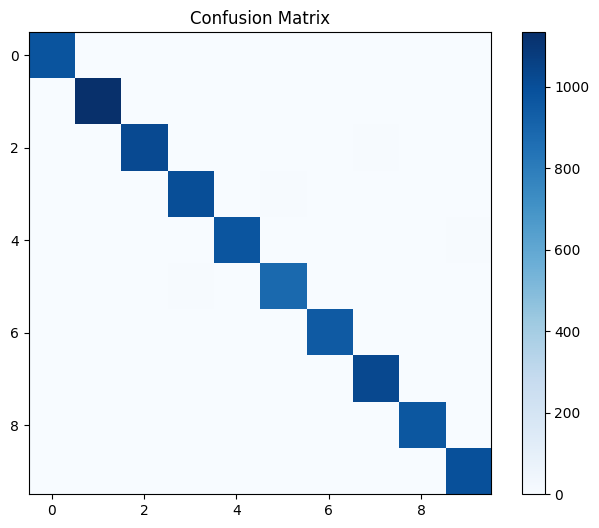

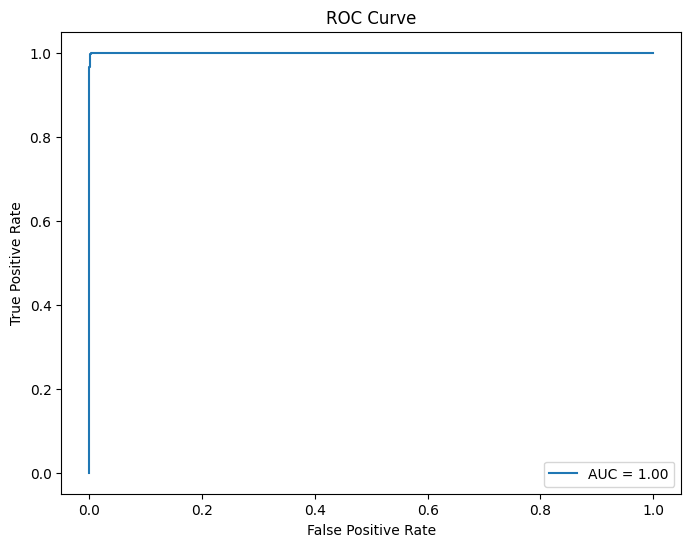

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape for CNN input (28x28x1)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 output classes
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (80-20 split)
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=128)

# Evaluate model
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

# ROC and AUC
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


 CNN for CIFAR-10 Classification

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.3073 - loss: 1.8818 - val_accuracy: 0.5322 - val_loss: 1.2866
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5369 - loss: 1.3063 - val_accuracy: 0.6241 - val_loss: 1.0776
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6143 - loss: 1.0887 - val_accuracy: 0.6711 - val_loss: 0.9326
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6575 - loss: 0.9722 - val_accuracy: 0.6931 - val_loss: 0.8834
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7040 - loss: 0.8507 - val_accuracy: 0.6950 - val_loss: 0.8629
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7248 - loss: 0.7863 - val_accuracy: 0.7191 - val_loss: 0.8101
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7490 - loss: 0.7166 - val_accuracy: 0.7458 - val_loss: 0.7421
Epoch 8/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7695 - loss: 0.6556 - val_accuracy: 

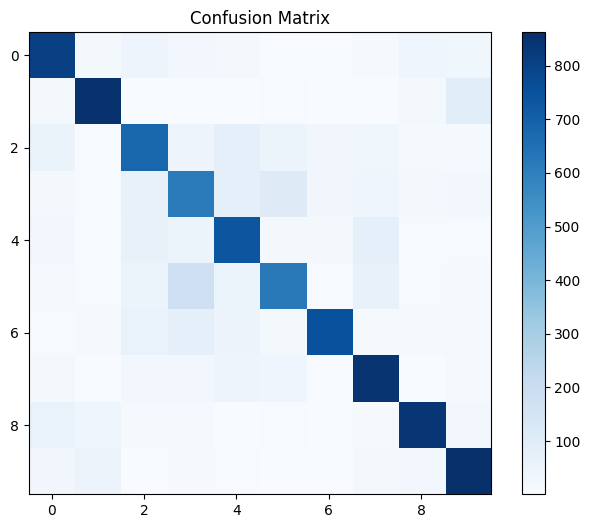

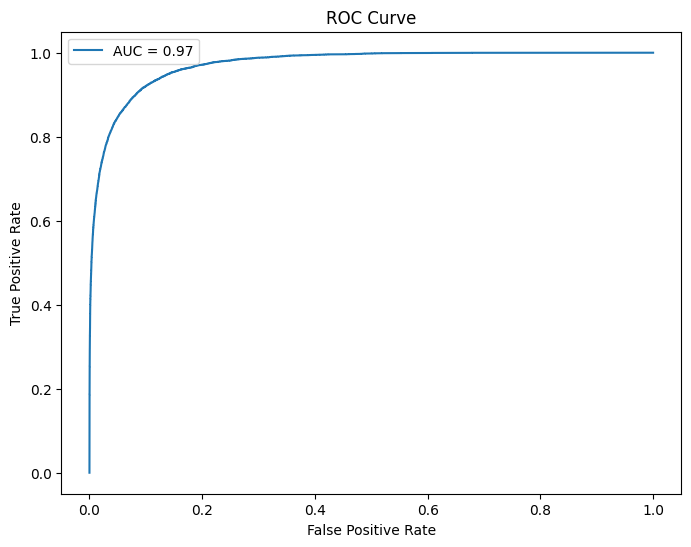

In [ ]:
from keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Build CNN model for CIFAR-10
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (80-20 split)
history = model.fit(x_train, y_train, epochs=15, validation_data=(x_test, y_test), batch_size=128)

# Evaluate model
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

# ROC and AUC
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

